In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

MAX_SIZE = 500

def draw_line(image, pt1, pt2, color=(0, 0, 0), thickness=2):
    cv2.line(image, tuple(pt1), tuple(pt2), color, thickness)

def draw_bottom_lines(image, vertex):
    line = []
    collision_index = None
    bottom_seq = range(vertex[1] + 2, MAX_SIZE, 1)

    for i in bottom_seq:
        line_point = [vertex[0], i]
        line.append(line_point)
    
        # Check for collision
        if (image[i, vertex[0]].all() == 0):
            collision_index = i

            if i != bottom_seq[0]:
                return [vertex[0], collision_index - 1]
            break

    if collision_index is None:
        return [vertex[0], MAX_SIZE]
    return None

def draw_top_lines(image, vertex):
    line = []
    collision_index = None

    top_seq = range(vertex[1] - 2, 0, -1)

    for i in top_seq:
        line_point = [vertex[0], i]
        line.append(line_point)
    
        # Check for collision
        if (image[i, vertex[0]].all() == 0):
            collision_index = i

            if i != top_seq[0]:
                return [vertex[0], collision_index + 1]
            break

    if collision_index is None:
        return [vertex[0], 0]
    return None

height, width = MAX_SIZE, MAX_SIZE
image = np.ones((height, width, 3), dtype=np.uint8) * 255

vertices = [[180, 230], [270, 180], [300, 200], [250, 260], [350, 300], [200, 280]]
border = [[0, 270], [100, 100], [250, 50], [450, 100], [499, 250], [350, 400], [150, 400]]

pts1 = np.array([vertices[0], vertices[1], vertices[2], vertices[3], vertices[4], vertices[5]], np.int32).reshape((-1, 1, 2))
pts2 = np.array([border[0], border[1], border[2], border[3], border[4], border[5], border[6]], np.int32).reshape((-1, 1, 2))

mask = np.zeros((MAX_SIZE, MAX_SIZE), dtype=np.uint8)
cv2.fillPoly(mask, [pts2], 255)
mask_inv = cv2.bitwise_not(mask)
image[mask_inv == 255] = (0, 0, 0)

cv2.fillPoly(image, [pts1], (0, 0, 0))

exported_img = cv2.bitwise_not(image)
cv2.imwrite("map.png", exported_img)

sorted_vertices = sorted(vertices, key=lambda x: x[0])

for index, vertex in enumerate(sorted_vertices):
    bottom_point = draw_bottom_lines(image, vertex)
    top_point = draw_top_lines(image, vertex)

    if (bottom_point != None):
        draw_line(image, vertex, bottom_point)
    
    if (top_point != None):
        draw_line(image, vertex, top_point)

cv2.polylines(image, [pts1], isClosed=True, color=(0, 0, 0), thickness=2)
cv2.polylines(image, [pts2], isClosed=True, color=(0, 0, 0), thickness=2)

edges = []

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

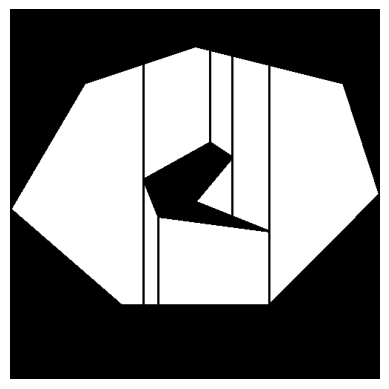

In [67]:
# a = np.array([bresenham_line(100, 100, 200, 50)], np.int32)
# pts = a.reshape((-1, 1, 2))
# cv2.polylines(image_rgb, [pts], isClosed=False, color=(0,200,120), thickness=2)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

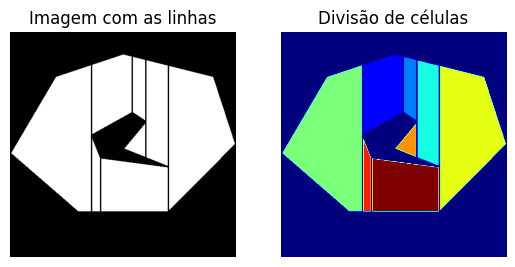

Number of cells found: 8


In [68]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
num_labels, labels_im = cv2.connectedComponents(binary)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Imagem com as linhas')

plt.subplot(1, 2, 2)
plt.imshow(labels_im, cmap='jet')
plt.axis('off')
plt.title('Divisão de células')
plt.show()

print(f"Number of cells found: {num_labels - 1}")

Cluster 1 - ponto central (x, y): (223, 132)
Cluster 2 - ponto central (x, y): (285, 124)
Cluster 3 - ponto central (x, y): (325, 179)
Cluster 4 - ponto central (x, y): (115, 238)
Cluster 5 - ponto central (x, y): (407, 219)
Cluster 6 - ponto central (x, y): (283, 247)
Cluster 7 - ponto central (x, y): (189, 328)
Cluster 8 - ponto central (x, y): (272, 344)


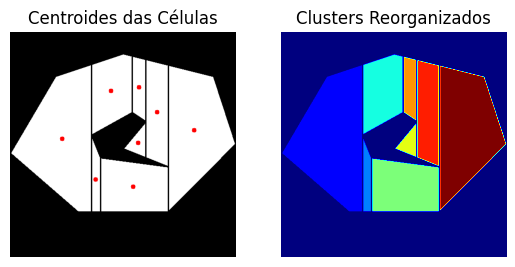

In [69]:
centroids = []
labels_im[labels_im == 0] = 0
num_labels = num_labels - 1

for cluster_index in range(1, num_labels + 1):
    cluster_mask = np.zeros_like(labels_im, dtype=np.uint8)
    cluster_mask[labels_im == cluster_index] = 255
    
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    center_x = int(np.mean(np.where(labels_im == cluster_index)[1]))
    center_y = int(np.mean(np.where(labels_im == cluster_index)[0]))
    centroids.append((cluster_index, (center_x, center_y)))

    print(f"Cluster {cluster_index} - ponto central (x, y): ({center_x}, {center_y})")

    cv2.circle(image, (center_x, center_y), 5, (0, 0, 255), -1)

centroids.sort(key=lambda x: x[1][0])

new_labels_im = np.zeros_like(labels_im)
for new_id, (old_id, centroid) in enumerate(centroids, start=1):
    new_labels_im[labels_im == old_id] = new_id

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Centroides das Células')

plt.subplot(1, 2, 2)
plt.imshow(new_labels_im, cmap='jet')
plt.axis('off')
plt.title('Clusters Reorganizados')
plt.show()

Células 1 e 2 são vizinhas. Distância mínima: 4.00
Células 1 e 3 são vizinhas. Distância mínima: 4.00
Células 1 e 4 não são vizinhas. Distância mínima: 24.00
Células 1 e 5 não são vizinhas. Distância mínima: 157.94
Células 1 e 6 não são vizinhas. Distância mínima: 94.15
Células 1 e 7 não são vizinhas. Distância mínima: 124.00
Células 1 e 8 não são vizinhas. Distância mínima: 174.00
Células 2 e 3 não são vizinhas. Distância mínima: 12.00
Células 2 e 4 são vizinhas. Distância mínima: 4.00
Células 2 e 5 não são vizinhas. Distância mínima: 58.52
Células 2 e 6 não são vizinhas. Distância mínima: 108.45
Células 2 e 7 não são vizinhas. Distância mínima: 104.00
Células 2 e 8 não são vizinhas. Distância mínima: 154.00
Células 3 e 4 não são vizinhas. Distância mínima: 58.52
Células 3 e 5 não são vizinhas. Distância mínima: 39.82
Células 3 e 6 são vizinhas. Distância mínima: 4.12
Células 3 e 7 não são vizinhas. Distância mínima: 35.00
Células 3 e 8 não são vizinhas. Distância mínima: 85.00
Célula

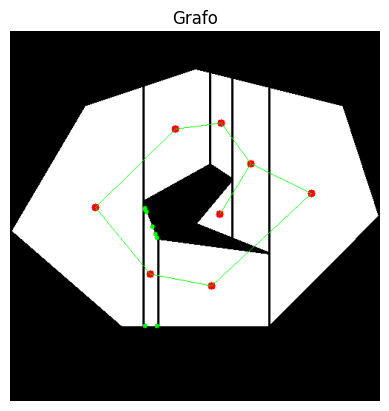

In [70]:
def min_distance_between_contours(contour1, contour2):
    min_dist = float('inf')
    for point in contour1:
        dist = cv2.pointPolygonTest(contour2, (int(point[0][0]), int(point[0][1])), True)
        if abs(dist) < min_dist:
            min_dist = abs(dist)
    return min_dist

distance_threshold = 4.15

contours_list = []
for i in range(1, num_labels + 1):
    cluster_mask = np.zeros_like(new_labels_im, dtype=np.uint8)
    cluster_mask[new_labels_im == i] = 255
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    if contours:
        # print(contours[0])
        # print(centroids[i-1])
        contours_list.append(contours[0])

for i in range(len(contours_list)):
    for j in range(i + 1, len(contours_list)):
        dist = min_distance_between_contours(contours_list[i], contours_list[j])
        if dist < distance_threshold:
            print(f"Células {i + 1} e {j + 1} são vizinhas. Distância mínima: {dist:.2f}")
            cv2.line(image, centroids[i][1], centroids[j][1], color=(0,255,0), thickness=1)
        else:
            print(f"Células {i + 1} e {j + 1} não são vizinhas. Distância mínima: {dist:.2f}")

image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours_list[1], -1, (0, 255, 0), 5)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grafo')
plt.show()